<a href="https://colab.research.google.com/github/ali-sowicz/air-quality-regression/blob/main/Air_Pollution_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import statsmodels.api as sm

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from yellowbrick.regressor import CooksDistance
from yellowbrick.regressor import ResidualsPlot


import math

#**Air Pollution Project**



##**Dataset**

The dataset contains circa 9000 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level within an Italian city. The data were recorded for a period of one year (March 2004 - February 2005).


The Dataset contains 15 columns, the variables are the following:

* Date: The respective date where the metal oxid ratio in the air was measured
* Time: The respective time of the day when the ratio was measured
* CO(GT): The concentration of CO (carbon oxide) in mg/m^3
* PT08.S1(CO): The concentration of tin oxide (nominally CO targeted)
* NMHC(GT): Non Metanic HydroCarbons concentration in microg/m^3
* C6H6(GT): Benzene concentration in microg/m^3
* PT08.S2(NMHC): Titania concentration (nominally NMHC targeted)
* NOx(GT): NOx (nitric oxide (NO) and nitrogen dioxide (NO2)) concentration in ppb
* PT08.S3(NOx): Tungsten oxide concentration (nominally NOx targeted)
* NO2(GT): Nitrogen dioxide concentration in microg/m^3
* PT08.S4(NO2): tungsten oxide concentration (nominally NO2 targeted)
* PT08.S5(O3): Indium oxide (nominally O3 targeted)
* T: Temperature (in °Celsius)
* RH: Relative Humidity (in %)
* AH: Absolute Humidity
* Unnnamed 15 - no info
* Unnamed 16 - no info



##What you will see in this notebook
The objective of this notebook is to test various regression models to predict nitrogen dioxide (NO2) levels from an air pollution dataset. This involves evaluating and comparing different models to identify which one performs best in terms of accuracy and predictive power.

**Why Use Regression?**

Regression is used because it allows us to:

- **Predict Outcomes**: Estimate the value of a dependent variable based on the values of independent variables.
- **Identify Relationships**: Understand the strength and nature of relationships between variables.
- **Make Informed Decision**s: Use the model to forecast future trends and make data-driven decisions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/ML/AirQualityUCI.csv"
df = pd.read_csv(file_path, sep=";")

After loading the dataset, we had a first look at the variables and entries

In [ ]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


We were interested in the variable types and saw that we have two different kinds: Object (categorical) and float64 (numerical)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


We thought that it was weird that some numerical columns like Temperature (and others) contain categorical variables, indicated by "object". Looking at the original excel file, we figured out that this is due to the form the entries are written: For example, the temperature of 14.1°C would be written with a comma (,) instead of a period (.) which python automatically reads as a string and not a float. This was the same for the other numerical columns. We therefore started converting them into floats by exchanging every comma to a period.

In [ ]:
# Change the data type of columns with comma-separated numbers to float64
for col in df.select_dtypes(include='object').columns:
    if df[col].str.contains(',').any():
        df[col] = df[col].str.replace(',', '.').astype(float)

We further looked at the rows in the excel tabula and saw a lot of -200 values which seemed suspicious.

From the description of the dataset from authors we know that -200 values are in fact null-values and not true measurements. From our own analysis we noticed that sometimes -2000 appears in the column CO(GT), we assumed that it was meant to be -200

In [ ]:
count_cells = ((df == -200) | (df == -2000)).sum()

print(f"The sum of -200 and -2000 is:")
print(count_cells)

The sum of -200 and -2000 is:
Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
Unnamed: 15         0
Unnamed: 16         0
dtype: int64


We replaced every -200 entry (and -2000) with NaN

In [ ]:
df = df.replace(-200, np.nan)
df = df.replace(-2000, np.nan)

Now we can look at all the NaN values in the dataset:

In [ ]:
df.isnull().sum()

Date              114
Time              114
CO(GT)           1797
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          480
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 480
RH                480
AH                480
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64

As we can see, the **NMHC** column has a lot of NaN values, so we decided to drop it.
The columns **Unnamed: 15** and **Unnamed: 16** only have null values so we dropped them as well.

In [ ]:
df = df.drop(columns=["Unnamed: 15","Unnamed: 16","NMHC(GT)"])

We discussed about what to do with all the other null values and finally decided to simply remove the rows that contain null values for every column.

In [ ]:
df = df.dropna()

In [ ]:
df

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139


So after all that cleaning and deleting we are left with 6941 rows, while we started with ca. 9k.

In [ ]:
df.isnull().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

After our first cleaning, we wanted to change the datatype of the dates from object to datetime. Further, we decided to extract from it more columns like month and day.

Also we noticed that the entries in the time column present the time in the format 10.00.00 but as in every entry, only the hour is shown (and not minutes or seconds), we decided to simplify the entries by deleting all the zeros and just show the hours.

In [ ]:
df["Date"] = pd.to_datetime(df["Date"], format='%d/%m/%Y', errors='coerce')
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["Time"] = df["Time"].apply(lambda x: float(x.split('.')[0]))

In [ ]:
columns_list = list(df.columns)
columns_list.insert(1, columns_list.pop(columns_list.index("Month")))
columns_list.insert(2, columns_list.pop(columns_list.index("Day")))
df = df[columns_list]
df.head()

,Date,Month,Day,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,3,10,18.0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10,3,10,19.0,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10,3,10,20.0,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10,3,10,21.0,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10,3,10,22.0,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6941 entries, 0 to 9356
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           6941 non-null   datetime64[ns]
 1   Month          6941 non-null   int32         
 2   Day            6941 non-null   int32         
 3   Time           6941 non-null   float64       
 4   CO(GT)         6941 non-null   float64       
 5   PT08.S1(CO)    6941 non-null   float64       
 6   C6H6(GT)       6941 non-null   float64       
 7   PT08.S2(NMHC)  6941 non-null   float64       
 8   NOx(GT)        6941 non-null   float64       
 9   PT08.S3(NOx)   6941 non-null   float64       
 10  NO2(GT)        6941 non-null   float64       
 11  PT08.S4(NO2)   6941 non-null   float64       
 12  PT08.S5(O3)    6941 non-null   float64       
 13  T              6941 non-null   float64       
 14  RH             6941 non-null   float64       
 15  AH             6941 non-nu

to recap, at this point:
- deleted empty rows and columns
- changed data types of metal oxides that were objects to float
- changed date data type
- extracted a column with months, days
- changed time data type and shortened it since the measurments were taken at o'clock - 18.00.00 -> 18.00


Box Plots

In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

columns = ['NO2(GT)', 'NOx(GT)', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
num_cols = 3  # Number of columns in the grid

# Create a figure with subplots
fig = make_subplots(rows=len(columns) // num_cols + (len(columns) % num_cols > 0), cols=num_cols, subplot_titles=columns)

# Plot each column as a box plot in the corresponding subplot
for i, col in enumerate(columns):
    row = i // num_cols + 1
    ncol = i % num_cols + 1
    trace = go.Violin(y=df[col], name=col)
    fig.add_trace(trace, row=row, col=ncol)

# Adjust layout and display the figure
fig.update_layout(height=800, width=800, title_text="Box Plots for Columns")
fig.show()



In case the plotly plot doesn't show in github view:
![Image Name](https://drive.google.com/uc?export=view&id=1WH3YjQHIo1W4e2D9zshxI0OAkvMLqymj)



## **Outlier Analysis**

The box plots reveal that all the elements have outliers, which likely represent extreme values significantly different from the majority of observations in air quality measurements. These outliers indicate unusual spikes or drops in pollutant concentrations or environmental conditions, deviating from typical patterns. Such deviations can impact statistical measures, model performance, and overall data interpretation. Visualizing and detecting outliers help us identify and address them appropriately in our dataset.

To understand the reasons behind these outliers in pollution levels and determine their relevance, **further investigation is required**. Various factors, such as measurement errors, extreme weather conditions, or malfunctioning sensors, could cause these outliers. We assume the dataset reflects real-life situations with spikes in air pollution.

Given the limited knowledge about the nature of air pollution measurements, and without additional information about the dataset, we have decided to retain the outliers for now.

In [ ]:
# Dropping the date column since we extracted months and days
df1 = df.drop(columns=['Date'])

Here we just check all our columns:

In [ ]:
df1.columns

Index(['Month', 'Day', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

We chose NO2 as our target variable and scale it here with the logarithm, the explanations are below

In [ ]:
log_NO2=np.log(df1['NO2(GT)'])
df1['log_NO2(GT)']=log_NO2

In [ ]:
X = df1[['Month', 'Day', 'Time', 'T', 'RH', 'AH','NOx(GT)', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
y = df1[['log_NO2(GT)']]

##Why NO2?
We decided to look at the relation between NO2 and the air quality, because NO2 is particularly harmful to respiratory health and it can harm human health and contribute to the formation of smog and acid rain. We thought it is one of the most influential chemical compounds to the air quality and therefore decided to proceed to do the analyses and models on NO2.

##Why log(NO2)?
When we started to do this project and run the regression models on the non-modified NO2, the models showed signs of *heteroscedasticity* in the residual plots: The residuals appeared more dispersed for higher predicted values, indicating the variance was not constant.

To address this issue, we transformed the target variable by taking the natural log of NO2, resulting in log(NO2). This transformation stabilized the variance of the residuals, as evident in the improved residual plots. Using the transformation, it made the data more suitable for statistical analyses. Given the better performance with the log-transformed target, we have decided to proceed with log(NO2) for the rest of the analysis.

Below, we have included an example of the metrics and residual plot for a linear regression model before applying the log transformation to the target variable.

Note that before coming to this conclusion we tested every regression model from this notebook, and each one had a similar case of heteroscedasticity.

![Image Name](https://drive.google.com/uc?export=view&id=1O693BSUs1-mrcw506YK2RuzbcmVIWy8z)




##**Start with splitting into test and train set**

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We need to scale the test and training set to handle the different scales of the variables and make the outputs more comparable **right??**

In [ ]:
# Scale the input features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train) # No target

X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)


In [ ]:
#Data-Size
print('Training Data Size:',X_train.shape)
print('Test Data Size:',X_test.shape)

Training Data Size: (5552, 14)
Test Data Size: (1389, 14)


In [ ]:
X_train

,Month,Day,Time,T,RH,AH,NOx(GT),CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
0,-0.295124,-1.505435,-1.754605,0.033403,0.024359,0.065063,-0.733416,-0.399316,-0.400021,-0.455925,-0.361524,0.337253,0.239264,-0.566687
1,-0.009118,-1.160232,0.445884,0.663093,-0.619671,0.272399,-0.950462,-1.016885,-1.372488,-0.921194,-1.012516,1.906355,-0.040659,-1.330171
2,1.420912,-1.045164,-0.434311,-0.247708,-0.372410,-0.605100,-0.719260,-1.016885,-1.554258,-1.147182,-1.418916,1.763709,-1.375245,-1.444815
3,-1.153142,1.256191,0.445884,-1.001087,-0.510416,-1.319176,-0.714542,-0.879647,-1.040759,-1.107302,-1.339894,0.931610,-1.827647,-1.625320
4,1.706918,-1.045164,1.179381,-0.315175,0.547633,0.004434,0.172515,0.149634,-0.018305,0.142279,0.296994,-0.669191,-0.193345,0.348030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5547,1.134906,1.601394,-1.754605,-0.045308,1.783941,1.451547,0.465056,0.149634,0.018049,-0.083709,0.059927,-0.506733,0.199679,-0.142258
5548,-1.439148,-0.469825,-1.461206,-0.731220,1.231915,-0.125308,0.606607,-0.056222,0.249806,-0.190056,-0.056724,-0.760326,-0.433683,0.499263
5549,-1.439148,-0.354758,0.592584,-0.472597,0.513132,-0.222614,0.535831,0.355490,0.717862,0.700603,0.820046,-1.136752,0.086579,0.828561
5550,-1.439148,0.565784,-1.461206,-1.237221,0.490131,-1.040731,-0.554117,-0.536554,-0.527260,-0.801554,-0.816842,0.115360,-1.293247,-0.022735


In [ ]:
file_path = "/content/drive/MyDrive/ML/"
X_train.to_csv(f"{file_path}X_train.csv", sep=",")
X_test.to_csv(f"{file_path}X_test.csv", sep=",")
y_train.to_csv(f"{file_path}y_train.csv", sep=",")
y_test.to_csv(f"{file_path}y_test.csv", sep=",")

In [ ]:
# change from (1389,1) to (1389,)
y_test = np.ravel(y_test)
y_train = np.ravel(y_train)

### `hyperp_search` method implements grid search cross-validation to find the optimal hyperparameters for a given regression model.
 It evaluates the model's performance using various metrics like MSE, RMSE, R2, and MAE on both training and test data. The method also visualizes residuals using a custom plot for model evaluation.

In [ ]:
import scipy.stats as stats
def hyperp_search(regressor, parameters):
    """
    Performs a hyperparameter search using GridSearchCV.

    Parameters:
    regressor (object): The regressor object to be used in the search.
    parameters (dict): A dictionary of hyperparameters to be searched.

    Returns:
    GridSearchCV: The fitted GridSearchCV object.
    """
    gs = GridSearchCV(regressor,
                      parameters,
                      cv=3,
                      scoring = 'neg_mean_squared_error',
                      verbose=0,
                      n_jobs=-1
                      )

    #counts time used by gridsearch
    tic = time.perf_counter()
    gs = gs.fit(X_train, y_train)
    toc = time.perf_counter()

    print("MSE_train: %f using %s in %.3f seconds" % (gs.best_score_, gs.best_params_,toc - tic))

    best_model = gs.best_estimator_
    y_pred_test = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)


    mse_tr, mse_test = mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)
    rmse_tr, rmse_test = np.sqrt(mean_squared_error(y_train, y_pred_train)), np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_tr, r2_test = r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test)
    mae_tr, mae_test = mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)
    #EVALUATE OUR PREDICTION
    print("           train    test ")
    print("-------------------------")
    print("MSE         %.3f    %.3f" % (mse_tr, mse_test))
    print("RMSE         %.3f    %.3f" % (rmse_tr, rmse_test))
    print("R2          %.3f    %.3f" % (r2_tr, r2_test))
    print("MAE         %.3f    %.3f" % (mae_tr, mae_test))
    print("")


    residuals_plot(best_model, X_train, y_train, X_test, y_test)


    return gs.best_estimator_, mse_test, rmse_test, r2_test, mae_test


In [ ]:
metrics_dict = {}

##**Models**

##What are we looking for when evaluating models?
**What are residual plots and how we interpret them:**

We write this here once and for the following plots we will describe just the respective interpretation.

In the left graph, we see the residuals plotted against the predicted values for our model. The residuals are the difference between predicted and actual value of our target variable. If our model is good, the residuals should be near zero. As the y-axis represents the residuals, the x-axis (thick black line) indicates the point where residuals would have the value 0 (which is what we want in the ideal case). The green and blue points around represent the residual values from train and test set (blue train, green test) which ideally should be spread around the x-axis zero line (as this represents a minimal residual error). Further, we want the spread of residuals to be equally distributed because then we know that the variance of residual error is constant, that the relationship between dependent and independent variable is linear. So there should not be a curve in the spread and the residuals should be equally distributed around the zero line.

In the right graph we then see a histogram of residuals/ the actual distribution of residuals (again, from test and training) which in the ideal case should be normally distributed. A normal distribution confirms that there is no bias. This is also one of the assumptions for linear regression.

**We use different evaluation functions which are to be minimized in the regression task.**

These are:
- Mean Squared Error (MSE)

It represents the average of the squares of the differences between the predicted and actual values. A lower MSE indicates a better fit of the model to the data, as the predictions are closer to the actual values. A higher MSE indicates a poorer fit of the model to the data, the predictions are farther from the actual values.

- Root Mean Squared Error (RMSE)

Is the square root of the mean squared error, bringing the scale of the errors to be the same as the scale of the targets. A lower RMSE indicates a better fit to the data  as the predictions are closer to the actual values. A higher RMSE indicate a poorer fit of the model to the data, the predictions are farther from the actual data

- R Squared (R²)

It indicates how much of the variation of a dependent variable is explained by an independent variable in a regression model. It goes from 0 to 1, where 1 indicates a perfect fit of the model to the data

- Mean Absolute Error (MAE)

It measures the average magnitude of the errors in a set of predictions, without considering their direction. (true values - predicted values), MAE takes the average of this error from every sample in a dataset and gives the output.



### **Linear Regressor**


Linear regression is a method used to predict a continuous target variable based on one or more input features. It models the relationship between the dependent variable (e.g., log(NO2)) and independent variables (other air quality features) by fitting a linear equation to the training data. The model learns the coefficients of this equation by minimizing the sum of squared residuals, which are the differences between predicted and actual values. Once trained, the model can make predictions for new data points using the learned coefficients.



MSE_train: -0.048645 using {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1} in 0.499 seconds
           train    test 
-------------------------
MSE         0.048    0.050
RMSE         0.220    0.223
R2          0.783    0.761
MAE         0.158    0.155



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



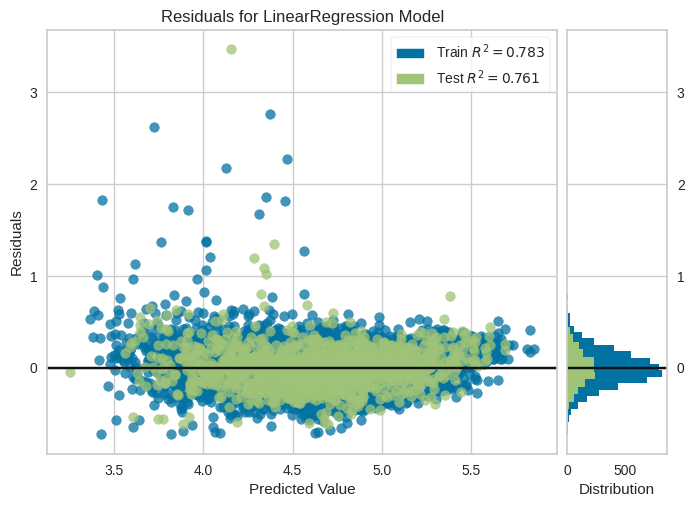

In [ ]:
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import residuals_plot

model= LinearRegression()
parameters = {'fit_intercept': [True, False],
              'copy_X': [True, False],
              'n_jobs':[1, 10, 20]}
best_lr, mse, rmse, r2, mae = hyperp_search(model,parameters)
metrics_dict["LinearRegression"] = {"mse": mse, "rmse": rmse, "r2": r2, "mae": mae }



**What we see in the residual plot for the linear regressor:**

We can see here that the residuals are mostly equally spread around the x-axis and mostly between -1 and 1 of the y-axis. This indicates that the linear regression model is an appropriate model to model the data. But we can also see some outliers (larger residuals) indicated by the blue and green dots with larger y values. Outliers can indicate data entry errors, special cases, or points that significantly influence the model.

The histogram of residuals on the right shows that the residuals are approximately normally distributed, which supports the assumption of normality of residuals.

In conclusion, the residual plot suggests that the model mostly meets the assumptions of linear regression, with residuals being centered around zero and showing a mostly consistent spread.


**What we see in the Evaluation Metrics**

Mean Squared Error (MSE) and Root Mean Squared Error (RMSE):

            train   test
    MSE    0.048    0.050
    RMSE   0.220    0.223


These values indicate that the model has low prediction errors on both the training and testing sets. The RMSE values are close, suggesting that the model generalizes well to unseen data.

R-Squared (R²):

          train   test
    R2    0.783    0.761

These values indicate that the model explains approximately 78.1% of the variance in the training data and 75.8% of the variance in the testing data. These values suggest a good/ strong fit, but they could be better.

Mean Absolute Error (MAE):

          train    test
    MAE   0.158    0.155

The values are quite low and similar for both the training and testing sets, further indicating that the model's predictions are accurate and that it performs consistently on new data.

**Conclusion:**

The linear regression model performs well, with low MSE, RMSE, and MAE values, and high R² values. This indicates that the model generalizes well from the training data to the testing data.

The consistency between training and testing metrics suggests that the model is not overfitting and is likely to perform well on new, unseen data.


###**KNN Regressor**

The KNN regressor is an algorithm that predicts the value of a target variable based on the values of its nearest neighbors, by finding the K nearest data points to a given input and averaging their target values it predicts the new data point. We have to choose the number K of neighbours, calculate the distance between the new input and the training data point, sort the distances and determine the nearest K neighbours, predict the target values by averaging the target values of the K nearest neighbors. Choosing a small K it could lead to a noisy prediction but a too large K could be overfitting.


MSE_train: -0.028778 using {'n_neighbors': 4} in 2.368 seconds
           train    test 
-------------------------
MSE         0.014    0.027
RMSE         0.120    0.165
R2          0.935    0.870
MAE         0.081    0.106



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



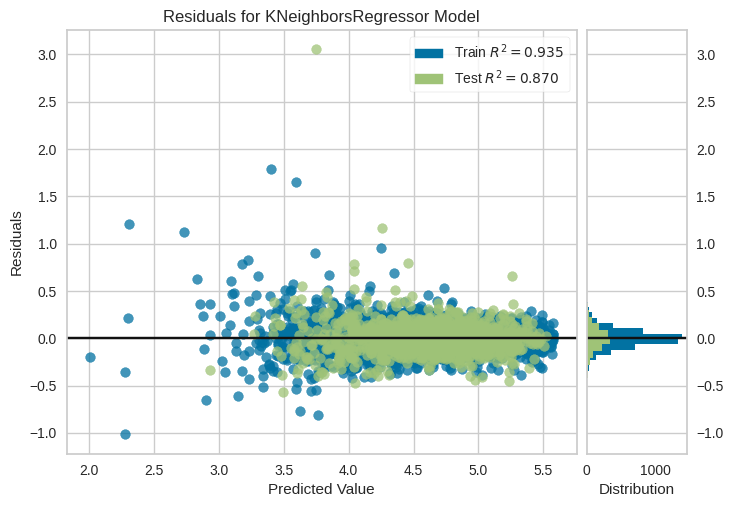

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
parameters = {'n_neighbors': [1,2,3,4,5,6,7]}  #we test for several amounts of neighbours
best_knr, mse, rmse, r2, mae = hyperp_search(model,parameters)
metrics_dict["KNeighborsRegressor"] = {"mse": mse, "rmse": rmse, "r2": r2, "mae": mae }

**What we can tell from the Residual Plot**

Also in this graph most of the values are scattered around the x-axis and the distribution looks even better than the linear regression model: instead of between -1 and 1 on the y axis, most of the values are scattered between y values of -0.5 and 0.5. This  and the almost equal spread of residuals indicate that the KNN Model is an appropriate model to use. But again what is also seen there are some outliers around 2.5 or -1, i.e. larger residuals, so while the KNN regressor may be better than the linear regression again there could be a better fitted model.

The residuals are generally centered around zero, which is a positive indication that the model's predictions are unbiased.

**Evaluation Metrics**

Mean Squared Error (MSE) and Root Mean Squared Error (RMSE):

            train    test
    MSE     0.014    0.027
    RMSE    0.120    0.165

These values indicate that the KNN Regressor has very low prediction errors on both the training and testing sets. The RMSE values are low, suggesting high accuracy in predictions.

R-Squared (R²):

          train   test
    R²    0.935    0.870

The R² values indicate that the model explains approximately 92.2% of the variance in the training data and 86.6% of the variance in the testing data. These values suggest a very strong fit and that the model generalizes well.

Mean Absolute Error (MAE):

           train   test
    MAE    0.081   0.106

The MAE values are very low and close for both the training and testing sets, indicating that the model's predictions are highly accurate and consistent across both datasets.

**conclusion**
Compared to the linear regression model, the KNN Regressor has significantly better performance metrics (lower MSE, RMSE, MAE, and higher R²). The residuals are also more tightly centered around zero with maybe slightly fewer extreme outliers.

###**Decision Tree Regressor**

It works by recursively partitioning the feature space into smaller regions and fitting a simple model (typically a constant) within each region. The splitting continues until a stopping criterion is met, here:
maximum depth, minimum samples per split, minimum samples per leaf

The quality of such a split is measured with one of these measures: 'squared_error', 'friedman_mse', 'absolute_error', or 'poisson'

The final prediction for a given input is the average of the target values in the corresponding leaf node

MSE_train: -0.025337 using {'criterion': 'poisson', 'max_depth': 40, 'min_samples_leaf': 5, 'min_samples_split': 20, 'splitter': 'best'} in 183.152 seconds
           train    test 
-------------------------
MSE         0.010    0.029
RMSE         0.098    0.172
R2          0.957    0.859
MAE         0.070    0.117



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names



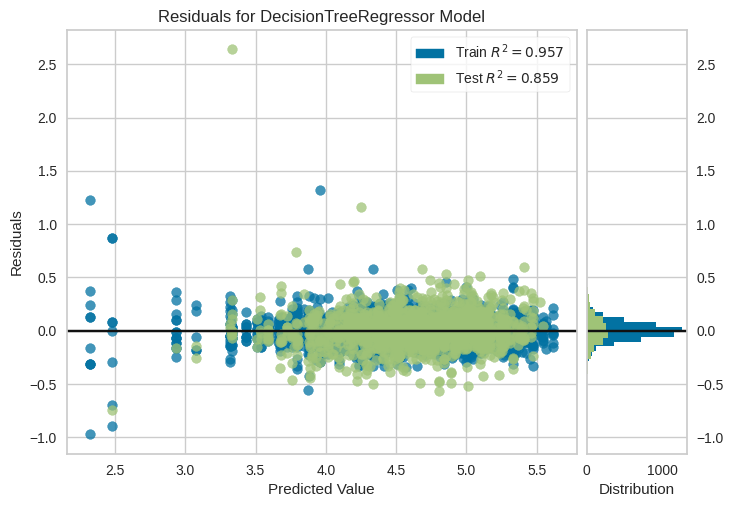

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model=DecisionTreeRegressor()
parameters = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
              'splitter' : ['best'],
              'max_depth': [4,5,6,8,10,15, 30, 40],
              'min_samples_split': [5,10,20],
              'min_samples_leaf': [5,10,20]}


best_tree, mse, rmse, r2, mae = hyperp_search(model,parameters)
metrics_dict["DecisionTreeRegressor"] = {"mse": mse, "rmse": rmse, "r2": r2, "mae": mae }

**Residuals Plot**

In this plot there are less random points outside the region of -.5 and 0.5, that indicates it is a better fitted model than the one above, because residuals nearer the x-axis indicate less prediction errors.

The residuals mostly show a consistent spread around the horizontal line which suggests that the variance of the residuals is constant.



**Metrics**

Mean Squared Error (MSE) and Root Mean Squared Error (RMSE):

            Train    Test
    MSE         0.010    0.029
    RMSE        0.098    0.172


The MSE and RMSE values are very low, indicating that the model has excellent accuracy in its predictions on both the training and testing sets.

R-Squared (R²):

         train     test
    R²   0.957    0.859

The R² values suggest that the model explains 94.9% of the variance in the training data and 86.6% in the testing data. This indicates a very strong fit on the training data and a robust performance on the testing data.

Mean Absolute Error (MAE):

          train    test
    MAE   0.070    0.117
The MAE values are low and close for both the training and testing sets, indicating that the model's predictions are very accurate and consistent across both datasets.

**Conclusion**

The models performance on the training data and testing data is also very strong, with low error metrics and a high R² value, indicating that the model generalizes well to unseen data.

Compared to the KNN Regressor, this model has a lower MSE, RMSE, and MAE on the training data and performs similarly on the testing data. The R² values are also slightly higher for the training data, suggesting that this model has a better fit on the training data.


###**Randomforest regressor**

The Random Forest Regressor is an ensemble learning method used for regression tasks. It works by constructing multiple decision trees during training and outputting the mean prediction of the individual trees.

The criteria and measurements are the same as in the decision tree above.

MSE_train: -0.016083 using {'criterion': 'poisson', 'max_depth': 40, 'min_samples_leaf': 5, 'min_samples_split': 10} in 7709.342 seconds
           train    test 
-------------------------
MSE         0.006    0.016
RMSE         0.079    0.128
R2          0.972    0.922
MAE         0.054    0.089



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



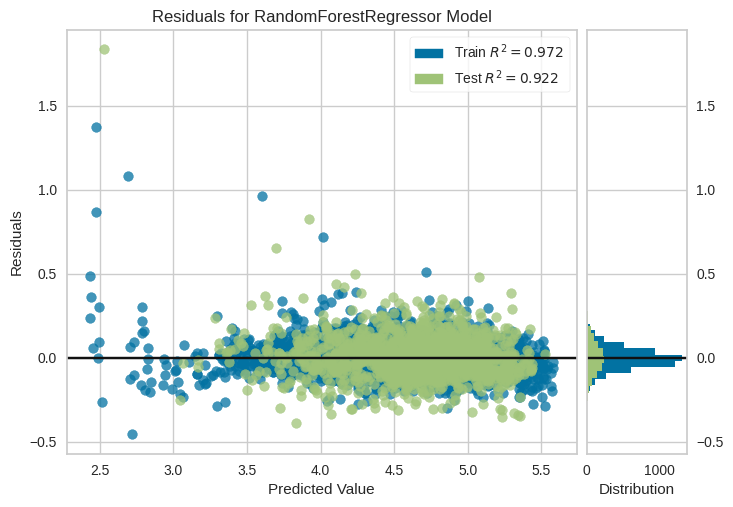

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
parameters = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
              'max_depth': [4,5,6,8,10,15, 30, 40],
              'min_samples_split': [5,10,20],
              'min_samples_leaf': [5,10,20]}

best_forest, mse, rmse, r2, mae = hyperp_search(model,parameters)
metrics_dict["RandomForestRegressor"] = {"mse": mse, "rmse": rmse, "r2": r2, "mae": mae }

**Residuals Plot**

As seen in the plot, most of the residuals lie between -0.5 and 0.5 and there are not a lot of values scattered randomly around. Again, we have a few outliers but the scatter plot seems equally distributed, indicating a constant variance and therefore no bias. This model seems to be better than the models before.


**metrics**

Mean Squared Error (MSE) and Root Mean Squared Error (RMSE):

            train   test
    MSE     0.006    0.016
    RMSE    0.079    0.128

The MSE and RMSE values are very low for both the training and testing sets, indicating that the Random Forest Regressor has a good accuracy in its predictions.

R-Squared (R²):

            train     test
    R²      0.972    0.922

The R² values are very high, with the model explaining 97.2% of the variance in the training data and 92.3% in the testing data. This suggests a strong fit and robust performance on the testing data.

Mean Absolute Error (MAE):

          train    test
    MAE   0.054    0.089
The MAE values are very low and close for both the training and testing sets, indicating that the model's predictions are highly accurate and consistent.

**Conclusions**

The Random Forest Regressor model performs exceptionally well, with very low error metrics (MSE, RMSE, MAE) and very high R² values on both the training and testing sets. The metrics indicate that this model has a very strong fit and generalizes well to new data.

Compared to previous models, the Random Forest Regressor outperforms both the KNN Regressor and the earlier models with better metrics. It has the lowest MSE, RMSE, and MAE, as well as the highest R² values for both training and testing sets, suggesting a better performance in comparison to the other models.

###**multi-layer perceptron regressor**

The Multi-Layer Perceptron Regressor is a type of artificial neural network, where the goal is to predict a continuous target variable based on one or more input features.

It consists of an input layer, one or more hidden layers with non-linear activation functions, and an output layer. The hidden layers learn higher-order representations of the input features, allowing the model to capture complex non-linear relationships in the data. It is trained using backpropagation, a supervised learning algorithm that adjusts the weights of the connections between neurons to minimize the error between predicted and actual target value.

MSE_train: -0.021637 using {'batch_size': 50, 'learning_rate_init': 0.001, 'max_iter': 1500, 'random_state': 1} in 98.502 seconds
           train    test 
-------------------------
MSE         0.015    0.022
RMSE         0.124    0.149
R2          0.931    0.894
MAE         0.089    0.100



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MLPRegressor was fitted with feature names



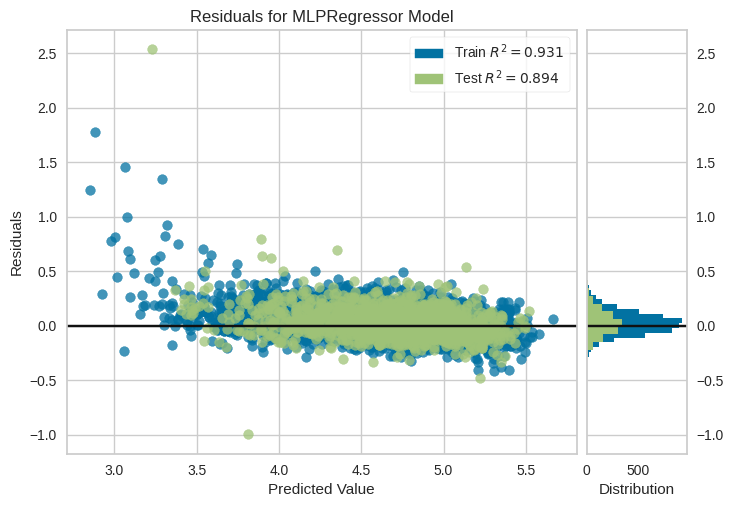

In [ ]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor()
parameters = {
              #number of samples that are processed before the model's parameters are updated during training
              'batch_size': ['auto', 100, 50],
              'learning_rate_init': [0.001, 0.01, 0.1],
              'max_iter': [1500,2000],
              'random_state': [1],
              }


best_mlp, mse, rmse, r2, mae = hyperp_search(model,parameters)
metrics_dict["MLPRegressor"] = {"mse": mse, "rmse": rmse, "r2": r2, "mae": mae }

**Residual Plot**

At first glance this model seems also really good, with an equal distribution of the residuals with a few outliers. But there are more random points scattered around than the Random Forest model, so it is an appropriate model, but maybe not the best.

On the right hand side we again see a normal distribution of the residuals.

**metrics**

Mean Squared Error (MSE) and Root Mean Squared Error (RMSE):

            train    test
    MSE     0.015    0.022
    RMSE    0.124    0.149

The MSE and RMSE values are low for both the training and testing sets, indicating good prediction accuracy. The slight increase in MSE and RMSE from training to testing suggests reasonable generalization capability.

R-Squared (R²):

          train   test
    R²     0.931    0.894

The R² values indicate that the model explains 94.4% of the variance in the training data and 90.2% in the testing data. These high values suggest a strong fit and robust performance on the testing data.

Mean Absolute Error (MAE):

            train   test
    MAE    0.089    0.100
The MAE values are low and close for both the training and testing sets, indicating that the model's predictions are accurate and consistent.

**Conclusions**

The MLP Regressor model performs well, with low error metrics (MSE, RMSE, MAE) and high R² values for both training and testing sets. The metrics indicate a strong fit and good generalization capability to new data.

Compared to the Random Forest Regressor, the MLP Regressor has slightly higher MSE, RMSE, and MAE values and slightly lower R² values, suggesting that the Random Forest Regressor is the better model.
The MLP Regressor still performs better than the linear regression model and the KNN Regressor in terms of generalization and prediction accuracy.


###**Adaboost**

AdaBoost (adaptive boosting) works by combining multiple weak learners, often decision stumps (simple models slightly better than random chance), to make predictions.
AdaBoost uses short decision trees (weak learners) during training and prioritizes instances that are incorrectly classified for subsequent models.
The algorithm iteratively corrects the mistakes made by the previous models, focusing on instances with higher error.


MSE_train: -0.034117 using {'estimator': None, 'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 100, 'random_state': 42} in 348.903 seconds
           train    test 
-------------------------
MSE         0.033    0.035
RMSE         0.181    0.187
R2          0.852    0.833
MAE         0.146    0.146



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but AdaBoostRegressor was fitted with feature names



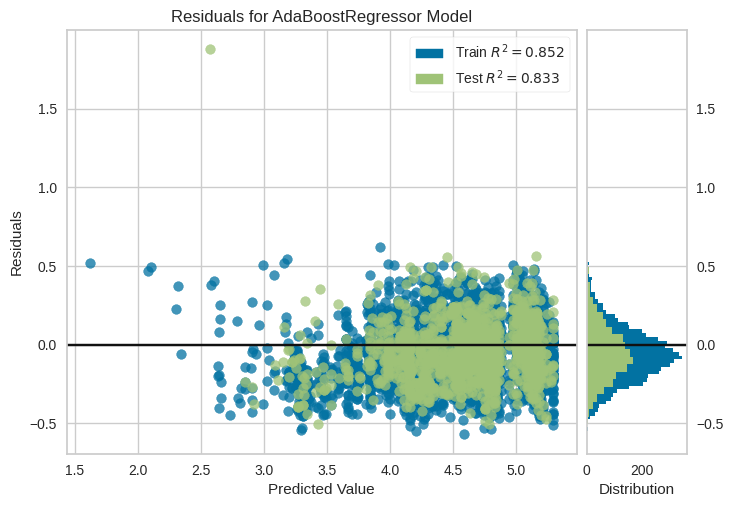

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor()
parameters = {
    'estimator': [None, DecisionTreeRegressor(max_depth=3)],
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'loss': ['linear', 'square', 'exponential'],
    'random_state': [None, 42]
}
ada_boost, mse, rmse, r2, mae = hyperp_search(model,parameters)
metrics_dict["AdaBoostRegressor"] = {"mse": mse, "rmse": rmse, "r2": r2, "mae": mae }

**Residual Plot**

In this plot, we see very few outliers and a distribution of the residuals between 0.5 and -0.5. The distribution could be more evenly spread though, the residuals seem to crowd more on the right side of the plot (**??**).

In the graph on the right side, we again see a normal distribution of the residuals which is, however, slightly shifted to the right side.

**metrics**

Mean Squared Error (MSE) and Root Mean Squared Error (RMSE):

            train   test
    MSE     0.033    0.035
    RMSE    0.181    0.187

The MSE and RMSE values are relatively low, indicating good prediction accuracy. The close match between the training and testing RMSE suggests that the model generalizes well and is not overfitting.

R-Squared (R²):

          train   test
    R²    0.852    0.833

The R² values indicate that the model explains 85.2% of the variance in the training data and 83.4% in the testing data. These values suggest a strong fit and robust performance on the testing data.

Mean Absolute Error (MAE):

          train   test
    MAE   0.146    0.146
The MAE values are identical for both the training and testing sets, indicating that the model's predictions are consistent and accurate across both datasets.

**Conclusions**

the AdaBoost Regressor model performs well, with relatively low error metrics (MSE, RMSE, MAE) and high R² values for both the training and testing sets. The close match between training and testing metrics indicates good generalization capability.

Compared to the Random Forest Regressor and the MLP Regressor, the AdaBoost Regressor has higher MSE, RMSE, and MAE values and lower R² values, suggesting that it is less accurate and explains less variance in the data.
The AdaBoost Regressor still performs reasonably well, but it is outperformed by the Random Forest and MLP Regressors.

the similarity between the training and testing metrics indicates minimal overfitting, suggesting that the model generalizes well to unseen data.

###**Ridge Regressor**

Ridge regression is a statistical regularization technique. It corrects for overfitting on training data in ML models.

MSE_train: -0.048645 using {'alpha': 0.2} in 0.163 seconds
           train    test 
-------------------------
MSE         0.048    0.050
RMSE         0.220    0.223
R2          0.783    0.761
MAE         0.158    0.155



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but Ridge was fitted with feature names



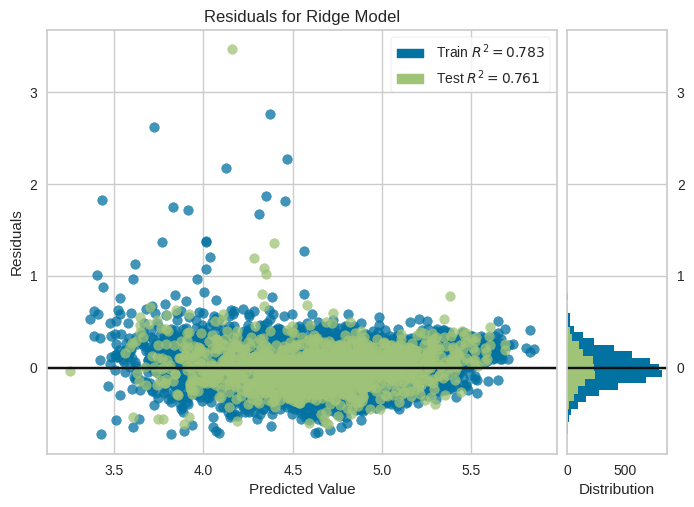

In [ ]:
from sklearn import linear_model
model= linear_model.Ridge(alpha=.5)
parameters = {'alpha': [0.2, 0.5, 0.7, 1]}
ridge, mse, rmse, r2, mae = hyperp_search(model,parameters)
metrics_dict["Ridge"] = {"mse": mse, "rmse": rmse, "r2": r2, "mae": mae }


**Residual Plot**

The distribution of residuals seems more even than the AdaBoost plot above. However, the residuals are again between -1 and 1 which is okay but worse than for example the Random Forest Model. We again see some outliers. The residuals are normally distributed as is to be seen in the histogram on the right.

Generally, this model seems to be a good fit but we have seen better models above.

**Metrics**

Mean Squared Error (MSE) and Root Mean Squared Error (RMSE):

            train   test
    MSE     0.048    0.050
    RMSE    0.220    0.223

The MSE and RMSE values are relatively low and quite similar between the training and testing sets, indicating that the Ridge Regressor has good prediction accuracy and generalization capability.

R-Squared (R²):

          train    test
    R²     0.783    0.761

The R² values indicate that the model explains 78.1% of the variance in the training data and 75.8% in the testing data. These values suggest a fairly strong fit and reasonable performance on the testing data.

Mean Absolute Error (MAE):

          train    test
    MAE   0.158    0.155
The MAE values are low and very close for both the training and testing sets, indicating that the model's predictions are consistent and reasonably accurate across both datasets.

**Conclusions**

The Ridge Regressor model performs well, with low error metrics (MSE, RMSE, MAE) and relatively high R² values for both the training and testing sets. The close match between training and testing metrics indicates good generalization capability.

Compared to models like the Random Forest Regressor and the Multi-Layer Perceptron (MLP) Regressor, the Ridge Regressor has higher MSE, RMSE, and MAE values and lower R² values, suggesting that it is less accurate and explains less variance in the data.
The Ridge Regressor performs similarly to the AdaBoost Regressor in terms of generalization, but with slightly higher error metrics and lower R² values.

The RandomForest Regressor still seems to be the best model which we want to confirm in the next step.

### **Find the Best Model**
We defined a method to find the best among the models based on the evaluation metrics (given as input)

In [ ]:
def find_best_model(metrics_dict, metric_to_optimize='r2', higher_is_better=True):
    """
    Finds the best model based on the specified metric.

    Args:
        metrics_dict (dict): A dictionary where the keys are model names and the values are
                            another dictionary containing the model's metrics.
        metric_to_optimize (str): The metric to use for selecting the best model.
                                 Default is 'r2'.
        higher_is_better (bool): Indicates whether a higher value of the metric is better.
                                Default is True.

    Returns:
        str: The name of the best model.
    """
    best_model = None
    best_metric_value = float('-inf') if higher_is_better else float('inf')     #sets best_metric_value to negative infinity or positive infinity depending on the boolean

    for model_name, model_metrics in metrics_dict.items():                      #actual calculation/ search for the best model
        metric_value = model_metrics[metric_to_optimize]
        if (higher_is_better and metric_value > best_metric_value) or \
           (not higher_is_better and metric_value < best_metric_value):
            best_model = model_name
            best_metric_value = metric_value

    return best_model


In [ ]:
best_model_r2 = find_best_model(metrics_dict)
best_model_mse = find_best_model(metrics_dict, metric_to_optimize='mse', higher_is_better=False)
best_model_rmse = find_best_model(metrics_dict, metric_to_optimize='rmse', higher_is_better=False)
best_model_mae = find_best_model(metrics_dict, metric_to_optimize='mae', higher_is_better=False)

In [ ]:
print(f'Best model r2 {best_model_r2}')
print(f'Best model mse {best_model_mse}')
print(f'Best model rmse {best_model_rmse}')
print(f'Best model mae {best_model_mae}')

Best model r2 RandomForestRegressor
Best model mse RandomForestRegressor
Best model rmse RandomForestRegressor
Best model mae RandomForestRegressor


According to this method and all the evaluation metrics, the Random Forest Model performs the best (not surprisingly).

In [ ]:
import pickle
pickle.dump(best_lr, open(f"{file_path}best_lr.pkl", 'wb'))
pickle.dump(best_knr, open(f"{file_path}best_knr.pkl", 'wb'))
pickle.dump(best_tree, open(f"{file_path}best_tree.pkl", 'wb'))
pickle.dump(best_forest, open(f"{file_path}best_forest.pkl", 'wb'))
pickle.dump(best_mlp, open(f"{file_path}best_mlp.pkl", 'wb'))
pickle.dump(ada_boost, open(f"{file_path}ada_boost.pkl", 'wb'))
pickle.dump(ridge, open(f"{file_path}ridge.pkl", 'wb'))

###**Shap**

SHAP is a method to look at how much each attribute contributes to the models prediction. We added it here out of interest.

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.0 MB/s eta 0:00:00


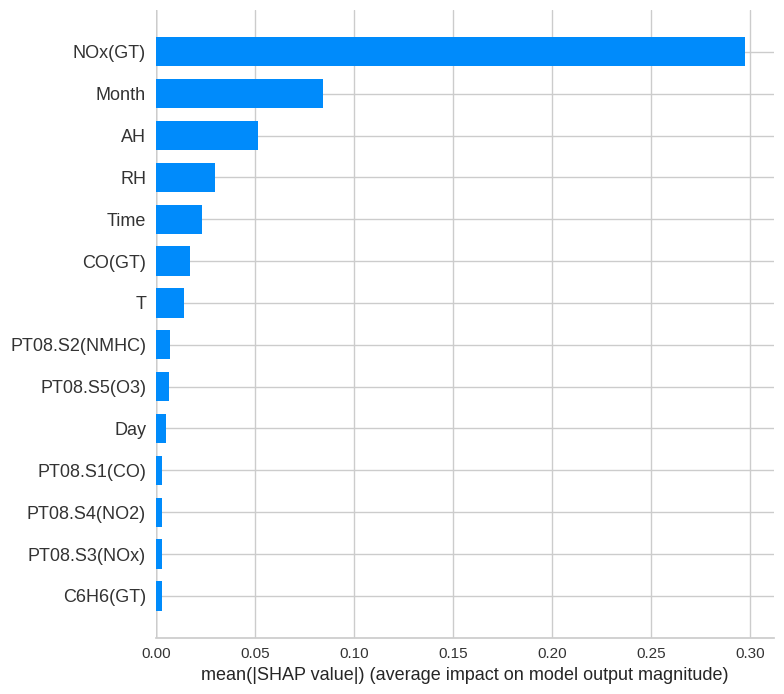

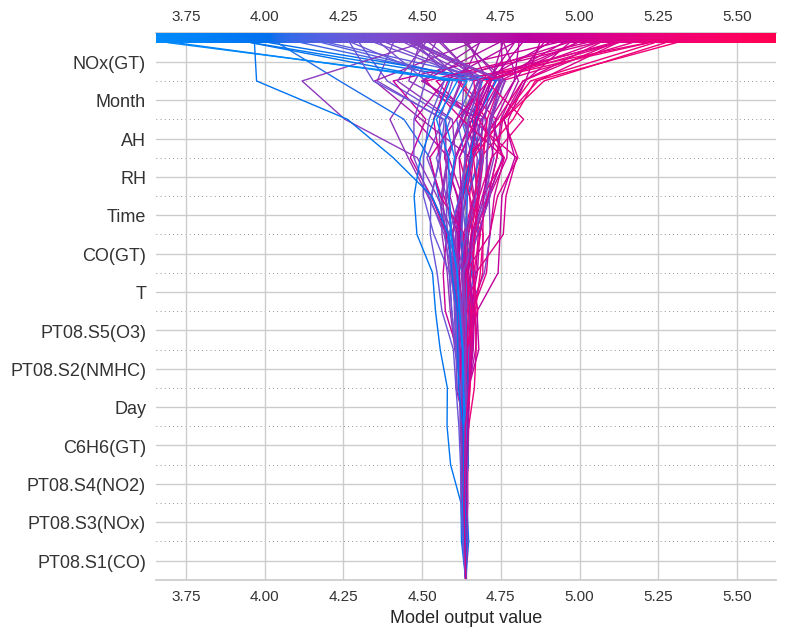

In [ ]:
import numpy as np
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
# Compute SHAP values
rf_model = best_forest
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Visualize feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

shap.initjs()
# decision plot for just the first instance
# shap.decision_plot(explainer.expected_value[0], shap_values[0], feature_names = list(X_test.columns))

#decision plot for the first 70 instances
num_instances = 70
# Select the first `num_instances` instances
selected_shap_values = shap_values[:num_instances]
selected_expected_values = explainer.expected_value[:num_instances]

# Generate the decision plot for the selected instances
shap.decision_plot(
    selected_expected_values,  # List of expected values for the selected instances
    selected_shap_values,  # List of SHAP values for the selected instances
    feature_names=list(X_test.columns)  # List of feature names
)


**Summary Plot**

- NOx level contribiutes the most to the NO2 prediction (as NO2 is part of NOx)
- Month and humidity have a huge impact as well
- the levels of other metal oxides do not matter as much

Apparently, the levels of NO2 seems to change within the months of a year and also the amount of humidity plays into the levels (and humidity levels also changes within a year). The other metal oxide levels do not seem to contribute a lot to the predictions.

**Multiple Decision Plot**

For x instances

- Again, most metal oxides do not have a huge or at most a minimal impact
- NOx always plays a role (obviously)
- month has an impact
- time as well
- humidity as well

-> they all either lead to increase or decrease of target variable, depending on instance

#**To summarize**

**Thoughts on why the Random Forest Regressor might have been the best model**


As the Random Forest Model is an ensemble of decision trees, which can capture non-linear relationships between features and the target variable effectively.
Each decision tree can use different
subsets of features and splits, capturing a wide range of interactions and dependencies.
This flexibility allows it to model complex patterns in the data that simpler linear models (like the linear Regressor) might miss.

Random Forest mitigates overfitting by averaging the predictions of multiple decision trees, each trained on different random subsets of the data and
features. This ensemble approach reduces variance and prevents the model from becoming too tailored to the training data.
The ensemble learning approach of Random Forest, where multiple weak learners (decision trees) are combined to form a strong learner, significantly boosts
predictive accuracy and robustness.

This is reflected in the results of the evaluation metrics:
The minimal difference between training and testing errors shows that the model generalizes well to new data, indicating
effective control of overfitting and showing a general good prediction accuracy.


To sum it up: The Random Forest Regressor's performance can be attributed to its ability to handle non-linearity, reduce
overfitting, and manage outliers and noise effectively. This makes the model better than the other models we have chosen for our regression task.